In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse.linalg as ll
from scipy.io import loadmat
import numpy as np
import time
import math
import seaborn as sns
import sys
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal as mvn
from sklearn.cluster import KMeans

In [14]:
# load images
images_data = loadmat('data.mat')['data']
label = loadmat('label.mat')['trueLabel']
data_transposed = images_data.transpose()

In [15]:
images_data.shape

(784L, 1990L)

In [16]:
#label data
label.reshape(1, 1990)

array([[2, 2, 2, ..., 6, 6, 6]], dtype=uint8)

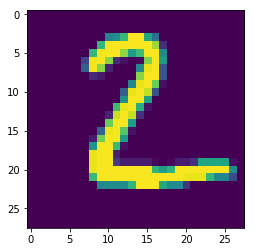

In [17]:
plt.imshow(data_transposed[0,:].reshape(28,28).transpose())
plt.show()

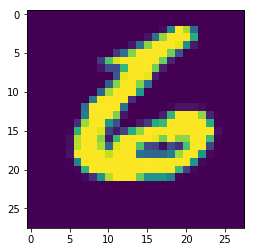

In [10]:
plt.imshow(data_transposed[len(data_transposed)-1,:].reshape(28,28).transpose())
plt.show()

In [19]:
#implement PCA on data to get the first 5 principal components
pca = PCA(n_components=5)
pca.fit(data_transposed)
x_new = pca.transform(data_transposed)
x_new.shape

(1990L, 5L)

In [138]:
maxIter= 200
tol = 1e-3
K = 2

# initialize prior
pi = np.random.random(K)
pi = pi/np.sum(pi)


identity = np.identity(5)
mean = np.ones(5)

mean1 = np.random.multivariate_normal(mean, identity)
mean2 = np.random.multivariate_normal(mean, identity)

s1 = np.random.multivariate_normal(mean,identity , (5)) 
sigma1 = np.dot(s1,s1.transpose())+identity
s2 = np.random.multivariate_normal(mean,identity , (5))
sigma2 = np.dot(s2,s2.transpose())+identity
sigma = np.vstack((sigma1, sigma2))

mu = np.vstack((mean1, mean2))


mu_old = mu.copy()

m,n = x_new.shape
    
# initialize the posterior
tau = np.full((m, K), fill_value=0.)


pdata = x_new

logLikelihood = []
likelihood = []

for ii in range(maxIter):

    # E-step 
    #calculate posterior probability
    for kk in range(K):

        tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[0], sigma[kk*5:(kk+1)*5])
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    logLikelihood.append(np.sum(np.log(sum_tau)))
    sum_tau.shape = (m,1) 

    likelihood.append(np.sum(sum_tau))
    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
    
    
    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = np.dot(pdata.T , tau[:,kk]) / np.sum(tau[:,kk], axis = 0)
        
        # update cov matrix
        dummy = pdata - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk*5:(kk+1)*5] = np.dot(np.dot(dummy.T , np.diag(tau[:,kk])), dummy) / np.sum(tau[:,kk], axis = 0)


In [130]:
#plot log likelihood function
iterations = np.linspace(1,100,100)
logLikelihood = np.array(logLikelihood)
likelihood = np.array(likelihood)

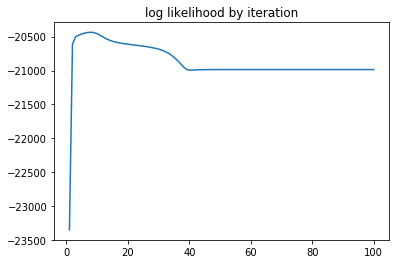

In [131]:
plt.plot(iterations , logLikelihood)
plt.title('log likelihood by iteration')
plt.show()

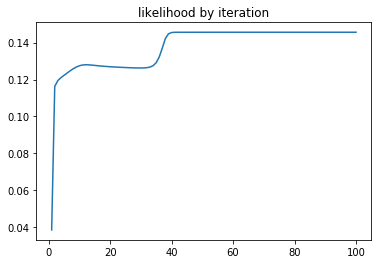

In [132]:
plt.plot(iterations , likelihood)
plt.title('likelihood by iteration')
plt.show()

In [28]:
#calculate new mu and new sigma

k=5
x = images_data
n,m = x.shape
x_bar = np.mean(x,axis = 1)
xc = x - x_bar[:,None]
C = np.dot(xc,xc.T)/m

eigenval, eigenvec = np.linalg.eig(C)
#find the index of sorted eigenvalues from largest to smallest
index = np.argsort(eigenval)[::-1]   

sorted_val = eigenval.real[index]
sorted_vec = eigenvec.real[:, index]

Z= np.zeros((x.shape[1],k))
for i in range(k):  
    z = np.dot(sorted_vec[:,i].T,xc)/math.sqrt(sorted_val[i]) # extract 1st eigenvalues
    Z[:,i]=z

#new mu    
D = np.diag(np.power(sorted_val[:k], (1.0/2.0)))
new_mu  = np.dot(np.dot(sorted_vec[:,:k],D),mu.reshape(5,2)) + x_bar[:,None]


#new sigma1
A = np.dot(np.dot(sorted_vec[:,:k],D),sigma[:5])
B =  np.dot(D,sorted_vec[:,:k].T)
sigma1_new = np.dot(A,B)

#new sigma2
A = np.dot(np.dot(sorted_vec[:,:k],D),sigma[5:])
B =  np.dot(D,sorted_vec[:,:k].T)
sigma2_new = np.dot(A,B)


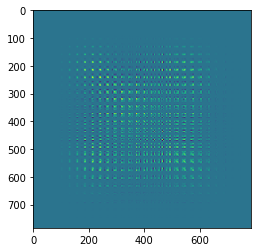

In [29]:
plt.imshow(sigma1_new)
plt.show()

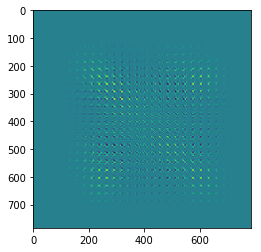

In [30]:
plt.imshow(sigma2_new)
plt.show()

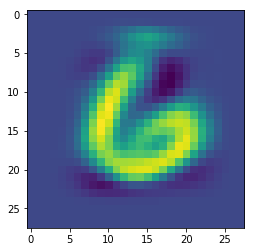

In [32]:
plt.imshow(new_mu[:,0].reshape(28,28).transpose())
plt.show()

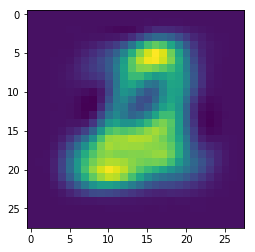

In [33]:
plt.imshow(new_mu[:,1].reshape(28,28).transpose())
plt.show()

In [34]:
pi

array([ 0.30127383,  0.69872617])

In [69]:
#Kmeans algorithm

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(x_new) 
data_labels = kmeans.labels_


#misclassifcation rate for kmeans for twos
cn = 0
cn_2 =0
for i in range(len(data_labels)):
    if label.reshape(1990,1)[i]==2:
        cn_2 = cn_2+1
        if data_labels[i]!=0:
            cn = cn+1
            
print 'misclassification rate for two is: '+ str((float(cn)/float(cn_2))*100) 

cn = 0
cn_6 =0
for i in range(len(data_labels)):
    if label.reshape(1990,1)[i]==6:
        cn_6 = cn_6+1
        if data_labels[i]!=1:
            cn = cn+1
            
print 'misclassification rate for six is: '+ str((float(cn)/float(cn_6))*100)

misclassification rate for two is: 7.36434108527
misclassification rate for six is: 4.69728601253


In [140]:
#calculate misclassification rate for GMM

label_6 = 0
true_6 = 0
label_2 = 0
true_2 = 0
for i in range(len(tau)):
    if label.reshape(1990,1)[i]==6:
        true_6 = true_6+1
        if tau[i][1]> 0.5:
            label_6 = label_6+1
    else:
        true_2 = true_2+1
        if tau[i][1]< 0.5:
            label_2 = label_2+1

print 'misclassification rate for six is: '+ str((float(label_6)/float(true_6))*100) 
print 'misclassification rate for two is: '+ str((float(label_2)/float(true_2))*100) 

misclassification rate for six is: 20.7724425887
misclassification rate for two is: 2.90697674419
